## Wrapper Methods

In this project, we'll analyze data from a survey conducted by Fabio Mendoza Palechor and Alexis de la Hoz Manotas that asked people about their eating habits and weight. The data was obtained from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition+). Categorical variables were changed to numerical ones in order to facilitate analysis.

First, we'll fit a logistic regression model to try to predict whether survey respondents are obese based on their answers to questions in the survey. After that, we'll use three different wrapper methods to choose a smaller feature subset.

We'll use:
* sequential forward selection
* sequential backward floating selection
* recursive feature elimination.

After implementing each wrapper method, we'll evaluate the model accuracy on the resulting smaller feature subsets and compare that with the model accuracy using all available features.

In [1]:
# Import libraries
import pandas as pd
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

## Evaluating a Logistic Regression Model

The data set `obesity` contains 18 predictor variables. Here's a brief description of them.

* `Gender` is `1` if a respondent is male and `0` if a respondent is female.
* `Age` is a respondent's age in years.
* `family_history_with_overweight` is `1` if a respondent has family member who is or was overweight, `0` if not.
* `FAVC` is `1` if a respondent eats high caloric food frequently, `0` if not.
* `FCVC` is `1` if a respondent usually eats vegetables in their meals, `0` if not.
* `NCP` represents how many main meals a respondent has daily (`0` for 1-2 meals, `1` for 3 meals, and `2` for more than 3 meals).
* `CAEC` represents how much food a respondent eats between meals on a scale of `0` to `3`.
* `SMOKE` is `1` if a respondent smokes, `0` if not.
* `CH2O` represents how much water a respondent drinks on a scale of `0` to `2`.
* `SCC` is `1` if a respondent monitors their caloric intake, `0` if not.
* `FAF` represents how much physical activity a respondent does on a scale of `0` to `3`.
* `TUE` represents how much time a respondent spends looking at devices with screens on a scale of `0` to `2`.
* `CALC` represents how often a respondent drinks alcohol on a scale of `0` to `3`.
* `Automobile`, `Bike`, `Motorbike`, `Public_Transportation`, and `Walking` indicate a respondent's primary mode of transportation. Their primary mode of transportation is indicated by a `1` and the other columns will contain a `0`.

The outcome variable, `NObeyesdad`, is a `1` if a patient is obese and a `0` if not.

We inspect the data.

In [2]:
# https://archive.ics.uci.edu/ml/datasets/Estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition+

# Load the data
obesity = pd.read_csv("obesity.csv")

# Inspect the data
obesity.head()

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,Automobile,Bike,Motorbike,Public_Transportation,Walking,NObeyesdad
0,0,21.0,1,0,2.0,3.0,1,0,2.0,0,0.0,1.0,0,0,0,0,1,0,0
1,0,21.0,1,0,3.0,3.0,1,1,3.0,1,3.0,0.0,1,0,0,0,1,0,0
2,1,23.0,1,0,2.0,3.0,1,0,2.0,0,2.0,1.0,2,0,0,0,1,0,0
3,1,27.0,0,0,3.0,3.0,1,0,2.0,0,2.0,0.0,2,0,0,0,0,1,0
4,1,22.0,0,0,2.0,1.0,1,0,2.0,0,0.0,0.0,1,0,0,0,1,0,0


### Split the data into `X` and `y`

In order to use a linear regression model, we need to split the data into two parts: the predictor variables and an outcome variable.

In [3]:
#X = obesity.iloc[:,:-1]
X = obesity.drop(["NObeyesdad"], axis=1)
X.head()

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,Automobile,Bike,Motorbike,Public_Transportation,Walking
0,0,21.0,1,0,2.0,3.0,1,0,2.0,0,0.0,1.0,0,0,0,0,1,0
1,0,21.0,1,0,3.0,3.0,1,1,3.0,1,3.0,0.0,1,0,0,0,1,0
2,1,23.0,1,0,2.0,3.0,1,0,2.0,0,2.0,1.0,2,0,0,0,1,0
3,1,27.0,0,0,3.0,3.0,1,0,2.0,0,2.0,0.0,2,0,0,0,0,1
4,1,22.0,0,0,2.0,1.0,1,0,2.0,0,0.0,0.0,1,0,0,0,1,0


In [4]:
#y = obesity.iloc[:,-1]
y = obesity.NObeyesdad
y.head()

0    0
1    0
2    0
3    0
4    0
Name: NObeyesdad, dtype: int64

### Logistic regression model

Now we create a logistic regression model called `lr`. We'll include the parameter `max_iter=1000` to make sure that the model will converge when we try to fit it.

In [5]:
lr = LogisticRegression(max_iter=1000)

### Fit the model

Use the `.fit()` method on `lr` to fit the model to `X` and `y`.

In [6]:
lr.fit(X, y)

LogisticRegression(max_iter=1000)

### Model accuracy

A model's _accuracy_ is the proportion of classes that the model correctly predicts. We compute the accuracy of `lr` by using the `.score()` method. What percentage of respondents did the model correctly predict as being either obese or not obese?

In [7]:
mod_acc = lr.score(X, y)
mod_acc

0.7659876835622927

## Sequential Forward Selection

Now we've created a logistic regression model and evaluated its performance, we're ready to do some feature selection. 

We create a sequential forward selection model called `sfs`. 
* We set the `estimator` parameter to `lr` and set the `forward` and `floating` parameters to the appropriate values. 
* Also we use the parameters `k_features=9`, `scoring='accuracy'`, and `cv=0`.

In [8]:
sfs = SFS(lr, forward=True, floating=False, k_features=9, scoring='accuracy', cv=0)

### Fit the model

We fit the model `sfs` to `X` and `y`.

In [10]:
sfs.fit(X, y)

SequentialFeatureSelector(cv=0, estimator=LogisticRegression(max_iter=1000),
                          k_features=(9, 9), scoring='accuracy')

### Inspect the first results

Now we can see what features were chosen and we can check the model accuracy on the smaller feature set.

In [11]:
sfs.subsets_[9]

{'feature_idx': (0, 1, 2, 3, 6, 9, 10, 14, 17),
 'cv_scores': array([0.78351492]),
 'avg_score': 0.7835149218379914,
 'feature_names': ('Gender',
  'Age',
  'family_history_with_overweight',
  'FAVC',
  'CAEC',
  'SCC',
  'FAF',
  'Bike',
  'Walking')}

In [12]:
sfs.subsets_[9]['feature_names']

('Gender',
 'Age',
 'family_history_with_overweight',
 'FAVC',
 'CAEC',
 'SCC',
 'FAF',
 'Bike',
 'Walking')

In [13]:
sfs.subsets_[9]['avg_score']

0.7835149218379914

### Visualize model accuracy

It can be helpful to visualize the results of sequential forward selection and see how accuracy is affected as each feature is added. We can use `plot_sfs` to plot the model accuracy as a function of the number of features used.

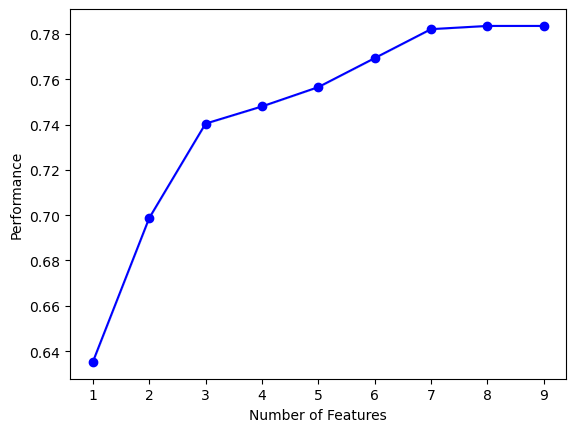

In [18]:
plot_sfs(sfs.get_metric_dict(),)
plt.show()

## Sequential Backward Selection

Sequential forward selection was able to find a feature subset that performed marginally better than the full feature set. Let's use a different sequential method and see how it compares.

We create a sequential backward selection model called `sbs`. 
* We set the `estimator` parameter to `lr` and set the `forward` and `floating` parameters to the appropriate values.
* Also use the parameters `k_features=7`, `scoring='accuracy'`, and `cv=0`.

In [19]:
sbs = SFS(lr, forward=False, floating=False, k_features=7, scoring='accuracy', cv=0)

### Fit the model


In [20]:
sbs.fit(X, y)

SequentialFeatureSelector(cv=0, estimator=LogisticRegression(max_iter=1000),
                          forward=False, k_features=(7, 7), scoring='accuracy')

### Inspect the results

Now we've run the sequential backward selection algorithm on the logistic regression model with `X` and `y`.
We can see what features were chosen and we can check the model accuracy on the smaller feature set.

In [21]:
sbs.subsets_[7]

{'feature_idx': (0, 1, 2, 3, 6, 9, 10),
 'cv_scores': array([0.78209379]),
 'avg_score': 0.7820937944102321,
 'feature_names': ('Gender',
  'Age',
  'family_history_with_overweight',
  'FAVC',
  'CAEC',
  'SCC',
  'FAF')}

In [22]:
sbs.subsets_[7]['feature_names']

('Gender',
 'Age',
 'family_history_with_overweight',
 'FAVC',
 'CAEC',
 'SCC',
 'FAF')

In [23]:
sbs.subsets_[7]['avg_score']

0.7820937944102321

### Visualize model accuracy

Let's visualize the results of sequential backward floating selection just as we did with sequential forward selection.

C:\ProgramData\anaconda3\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\anaconda3\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


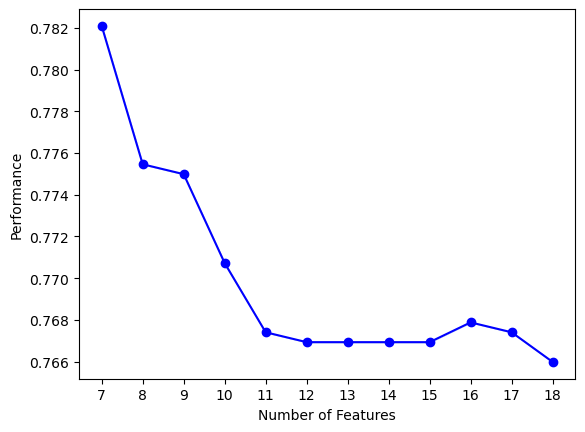

In [24]:
plot_sfs(sbs.get_metric_dict())
plt.show()

## Recursive Feature Elimination

Let's try one more: recursive feature elimination. First we'll standardize the data, then we'll fit the RFE model and inspect the results.


In [25]:
features = X.columns

### Standardize the data

Before doing applying recursive feature elimination it is necessary to standardize the data. Let's standardize `X` and save it as a DataFrame by creating a `StandardScaler()` object and using the `.fit_transform()` method.

In [26]:
X_s = pd.DataFrame(StandardScaler().fit_transform(X))

### Recursive feature elimination model

Now we create an `RFE()` object that selects `8` features. We set the `estimator` parameter to `lr`.

In [27]:
rfe = RFE(estimator=lr, n_features_to_select=8)

### Fit the model


In [28]:
rfe.fit(X_s, y)

RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=8)

### Inspect chosen features

Now we've fit the RFE model and we can evaluate the results. We create a list of chosen feature names and call it `rfe_features`. 

In [29]:
rfe_features = [f for (f,support) in zip(features, rfe.support_) if support]
rfe_features

['Age',
 'family_history_with_overweight',
 'FAVC',
 'FCVC',
 'CAEC',
 'SCC',
 'Automobile',
 'Walking']

### Model accuracy

We use the `.score()` method on `rfe` and print the model accuracy after doing recursive feature elimination.

Now we can compare the model's accuracy on all available features!

In [30]:
rfe.score(X_s, y)

0.7678825201326386